# Calculate data for REZ regions

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:04:00'
cores = 2
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.21.30:8787/status,
Dashboard: http://10.6.21.30:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.21.30:34753,Workers: 0
Dashboard: http://10.6.21.30:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

In [7]:
import functions as fn

plt_params = fn.get_plot_params()

# Load REZ mask

In [8]:
rez_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc'
).REZ

# Load gridded data

First look at daily (1400). Have already looked at hourly and daily (0000).

In [9]:
years = range(1959, 2021)

Mean solar shortwave radiation downwards

In [10]:
mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

100m wind speed

In [11]:
w100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region.zarr',
    consolidated=True
)

# Calculate regional averages

In [12]:
def REZ_spatial_mean(da, region):
    region_mask = rez_mask.sel(region=region)
    return da.where(region_mask, drop=True).mean(['lat', 'lon'], skipna=True)

In [13]:
def calculate_spatial_means(da):
    
    da_list = []
    for region in rez_mask['region'].values:
        region_mean = REZ_spatial_mean(da, region)
        da_list.append(region_mean)
        
    da_concat = xr.concat(
        da_list,
        dim='region'
    )
    return da_concat

In [14]:
rez_100w = calculate_spatial_means(w100['w100']).compute()

In [15]:
rez_mssrd = calculate_spatial_means(mssrd['msdwswrf']).compute()

# How often to regional means exceed operational thresholds?

- For wind, we use 4 m/s (Ridder report)
- For solar, use 170 W/m^2 (Prasad 2021), or 95 W/m^2 (calculated from 342 kJ/hr in Ridder report using https://www.unitconverters.net/power/kilojoule-hour-to-watt.htm)

In [16]:
thresh_100w = 4
thresh_mssrd = 170

In [45]:
def get_events(da, thresh, tail='lower'):
    if tail == 'lower':
        return xr.where(da < thresh, 1, 0)
    else:
        raise ValueError('Incorrect string for tail')

In [46]:
def calculate_event_frequency(da, thresh, tail='lower',
                             time_name='time'):
    T = len(da[time_name].values)
    events = get_events(da, thresh, tail)
    freq = events.sum(time_name) / T
            
    return freq

In [47]:
freq_100w = calculate_event_frequency(rez_100w, thresh_100w)

In [48]:
freq_mssrd = calculate_event_frequency(rez_mssrd, thresh_mssrd)

In [49]:
def plot_freq(da, region_codes=range(1,8), vmin=0, vmax='max'):

    with plt.rc_context(plt_params):
        regions = [rez_mask.region.values[i] for i in range(len(rez_mask.region.values)) if
                   rez_mask.region_code.values[i] in region_codes]
        plot_da = xr.where(rez_mask.sel(region=regions),
                           da.sel(region=regions),
                           np.nan).sum('region', skipna=True)
        plot_da = plot_da.where(rez_mask.sel(region=regions).sum('region'))
        
        if vmax == 'max':
            data_max = plot_da.max().values
            if data_max > 0.2:
                vmax=fn.round_decimals_up(data_max, 1)
                cbar_tick_intervals = 0.1
            else:
                vmax=fn.round_decimals_up(data_max, 2)
                cbar_tick_intervals = 0.01

        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
        ax.coastlines()
        ax.add_feature(
            cartopy.feature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces',
                                                scale='10m'),
            facecolor='none', edgecolor='k', lw=plt_params['lines.linewidth'] / 3
        )

        plot_da.plot(ax=ax, vmin=vmin, vmax=vmax,
                    cbar_kwargs={
                        'ticks': np.arange(vmin, vmax+.1, cbar_tick_intervals),
                        'label': 'Relative frequency [-]'
                    })

### Solar lulls

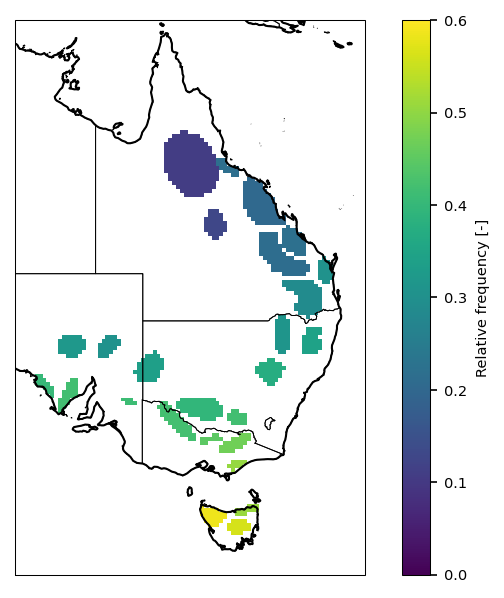

In [50]:
plot_freq(freq_mssrd, region_codes=[2, 3, 6, 7])

### Wind lulls

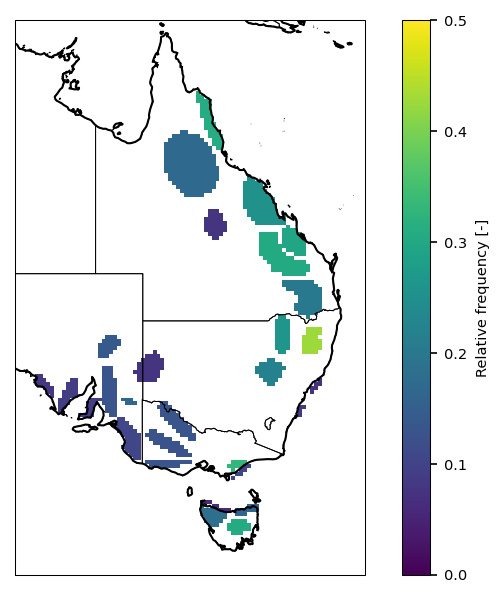

In [31]:
plot_freq(freq_100w, region_codes=[1, 3, 5, 7])

### Simultaneous wind and solar lulls

In [32]:
freq_100w_mssrd = xr.where(
    (rez_100w < thresh_100w) &
    (rez_mssrd < thresh_mssrd),
    1, 0
).sum('time') / len(rez_100w.time.values)

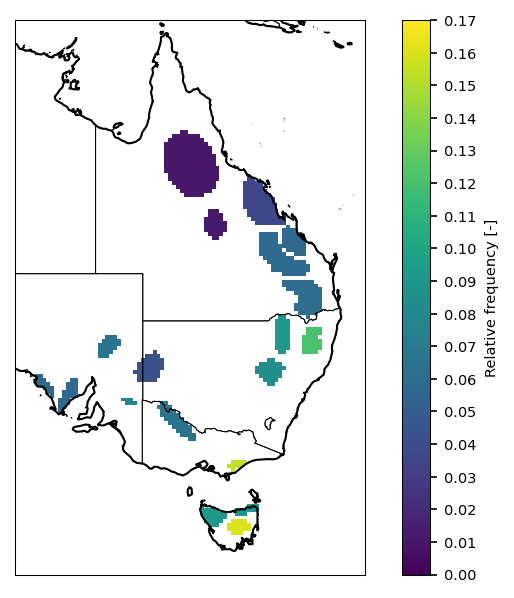

In [33]:
plot_freq(freq_100w_mssrd, region_codes=[3, 7])

# How often do these lulls occur simultaneously across regions?

In [51]:
events_100w = get_events(rez_100w, thresh_100w)

In [53]:
events_mssrd = get_events(rez_mssrd, thresh_mssrd)

### Avg number of regions per year experiencing lulls

#### Wind

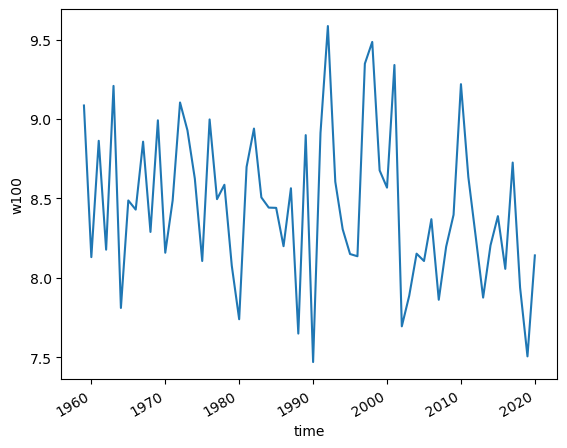

In [56]:
events_100w.sum('region').resample(time='1YS').mean().plot()

#### Solar

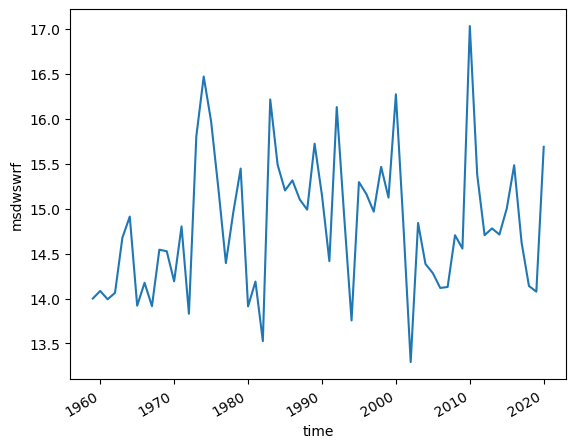

In [57]:
events_mssrd.sum('region').resample(time='1YS').mean().plot()

#### Both

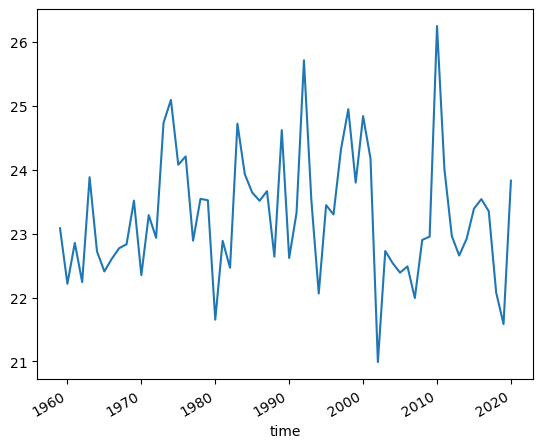

In [61]:
(events_100w + events_mssrd).sum('region').resample(time='1YS').mean().plot()

### Can we do a lego plot with days on the x and years on the y?

Could do one for each state, one for each energy type, one all together

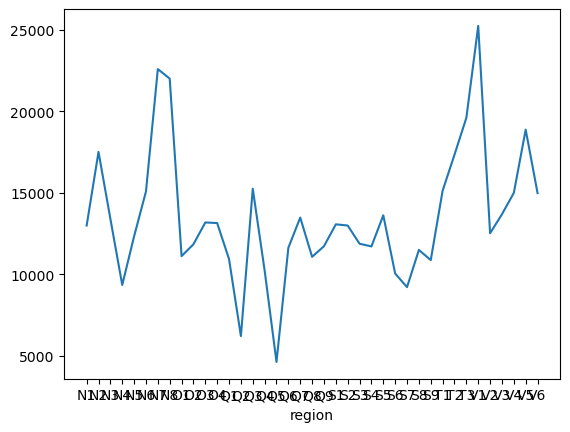

In [64]:
(events_100w + events_mssrd).sum('time').plot()

Remove leap year days (29/02) so that dayofyear can be used

In [118]:
i_leapdays = np.where(
    (events_100w.time.dt.month == 2) &
    (events_100w.time.dt.day == 29)
)[0]

In [120]:
i_exclude_leapdays = [i for i in range(len(events_100w.time)) if i not in i_leapdays]

In [134]:
def to_dayofyear(ds):
    year = ds.time.dt.year
    day = np.repeat(range(1, 366), 

    # assign new coords
    ds = ds.assign_coords(
        year=("time", year.data),
        day=("time", day)
    )

    # reshape the array to (..., "month", "year")
    return ds.set_index(
        time=("year", "day")
    ).unstack("time") 

In [136]:
events_100w.time.dt.year

<xarray.DataArray 'year' (time: 22646)>
array([1959, 1959, 1959, ..., 2020, 2020, 2020])
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01T14:00:00 ... 2020-12-31T14:00:00

In [135]:
testw = to_dayofyear(events_100w.isel(time=i_exclude_leapdays))
tests = to_dayofyear(events_mssrd.isel(time=i_exclude_leapdays))

ValueError: conflicting sizes for dimension 'time': length 365 on 'day' and length 22630 on {'time': 'time', 'region': 'region'}

In [131]:
np.unique(to_dayofyear(events_100w).day)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [128]:
np.unique(testw.day)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

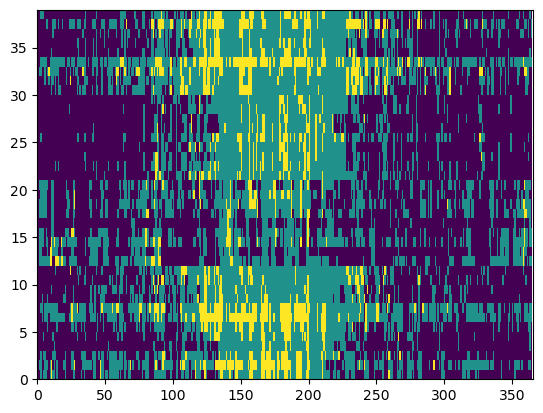

In [101]:
plt.pcolormesh((testw + tests).sel(year=1959).data)

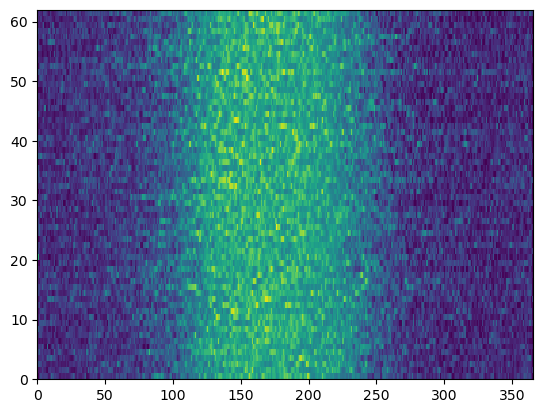

In [102]:
plt.pcolormesh((testw + tests).sum('region').data)

In [103]:
(testw + tests).sum('region')

<xarray.DataArray (year: 62, day: 366)>
array([[ 0.,  9., 16., ..., 16.,  8.,  0.],
       [ 4.,  5.,  7., ..., 10.,  5., 10.],
       [17., 18., 16., ...,  9.,  7.,  0.],
       ...,
       [ 7.,  8.,  6., ...,  6.,  7.,  0.],
       [ 9.,  6., 12., ...,  2.,  3.,  0.],
       [ 8., 10.,  8., ..., 21., 15., 12.]])
Coordinates:
  * year     (year) int64 1959 1960 1961 1962 1963 ... 2016 2017 2018 2019 2020
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366

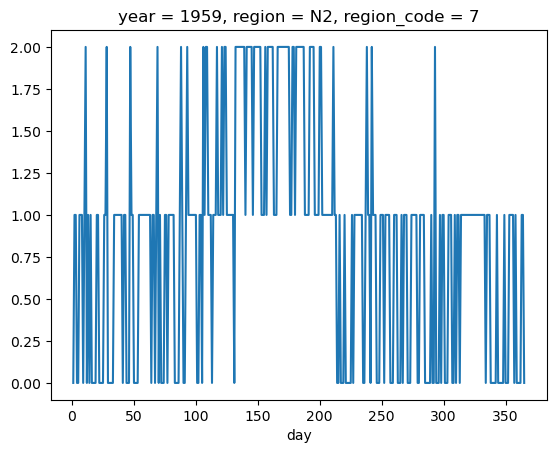

In [85]:
(testw + tests).sel(year=1959).plot()

# Close cluster

In [52]:
client.close()
cluster.close()